# Generalized Linear Models : Pynapple & Nemos

Pending:
- Present functions in a way that makes logical sense with the rest of the code
- Comment all functions
- Write explanations in markdown for all steps
- Find citations
- Revise again that the current way of storing stimuli for modeling (np.array) is indeed the best one
- Basis construction from compare_likelihood
- Organize your imports bro
- get two peri plots together (predicted and observed)
- Make id's consistent between units
- For perievents: maybe split neurons by firing rate? that would allow for the smaller firing rate ones not to be lost when compared to the large firing rate ones

q: responsiveness is currently being calculated as diff av fr before stimulus presentation and during presentation - should it be before and after instead?

what's the difference between using simulate and predict?


### Learning objectives
- Identify the steps in the process of fitting individual neural data using a GLM
- 
- 

Estimated time of completion: X minutes

- Add questions to ask self when completing the notebook for comprehension? With links to answers somewhere else?

### Downloading and opening files

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import jax
import pynapple as nap
import nemos as nmo

from math import ceil
from scipy import interpolate
from functools import reduce
from scipy.optimize import minimize
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from glm_utils import *

In [2]:
# Dataset information
dandiset_id = "000021"
dandi_filepath = "sub-726298249/sub-726298249_ses-754829445.nwb"
download_loc = "."

# Download the dataset
# t0 = perf_counter()
# io = nmo.fetch.download_dandi_data(dandiset_id, dandi_filepath)
# print(perf_counter() - t0)
# nap_nwb = nap.NWBFile(io.read(), lazy_loading=True)

# Open dataset with Pynapple
path = "sub-726298249_ses-754829445.nwb"
data = nap.load_file(path)
nwb = data.nwb

/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [3]:
data

sub-726298249_ses-754829445
┍━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━━━━┑
│ Keys                                               │ Type        │
┝━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━━━━┥
│ units                                              │ TsGroup     │
│ static_gratings_presentations                      │ IntervalSet │
│ spontaneous_presentations                          │ IntervalSet │
│ natural_scenes_presentations                       │ IntervalSet │
│ natural_movie_three_presentations                  │ IntervalSet │
│ natural_movie_one_presentations                    │ IntervalSet │
│ gabors_presentations                               │ IntervalSet │
│ flashes_presentations                              │ IntervalSet │
│ drifting_gratings_presentations                    │ IntervalSet │
│ timestamps                                         │ Tsd         │
│ running_wheel_rotation                             │ Tsd         │
│ runn

In [4]:
# Units and brain areas those units belong to are in two different places. With the electrodes table, we can map units to their corresponding brain regions.

def get_unit_location(unit_id):
    """Aligns location information from electrodes table with channel id from the units table
    """
    return channel_probes[int(units[unit_id].peak_channel_id)]

channel_probes = {}

electrodes = nwb.electrodes
for i in range(len(electrodes)):
    channel_id = electrodes["id"][i]
    location = electrodes["location"][i]
    channel_probes[channel_id] = location

units = data["units"]

# Add a new column to include location in our spikes TsGroup
units.brain_area = [channel_probes[int(ch_id)] for ch_id in units.peak_channel_id]

### Extracting data (spiking and stimulus)
Explanation of dataset

In [5]:
# Identify what brain location electrodes belong to
channel_probes = {}

electrodes = nwb.electrodes
for i in range(len(electrodes)):
    channel_id = electrodes["id"][i]
    location = electrodes["location"][i]
    channel_probes[channel_id] = location

print(channel_probes)

units = data["units"]

# There are many columns in this dataset which are not relevant to our goals so we can remove them.
def drop_cols(cols_to_keep, data):
    print(f"Previous columns {data.metadata_columns}")
    cols_to_remove = [col for col in data.metadata_columns if col not in cols_to_keep]
    data.drop_info(cols_to_remove)
    print(f"New columns after drop {data.metadata_columns}")

cols_to_keep = ['rate', 'quality', 'brain_area', 'peak_channel_id']
drop_cols(cols_to_keep,units)

{850135034: 'PoT', 850135036: 'PoT', 850135042: 'PoT', 850135046: 'PoT', 850135052: 'PoT', 850135058: 'PoT', 850135064: 'LP', 850135068: 'LP', 850135074: 'LP', 850135078: 'LP', 850135080: 'LP', 850135086: 'LP', 850135090: 'LP', 850135096: 'LP', 850135102: 'LP', 850135108: 'LP', 850135112: 'LGd', 850135118: 'LGd', 850135124: 'LGd', 850135130: 'LGd', 850135136: 'LGd', 850135140: 'LGd', 850135146: 'LGd', 850135152: 'LGd', 850135158: 'LGd', 850135162: 'LGd', 850135168: 'LGd', 850135174: 'LGd', 850135180: 'LGd', 850135186: 'LGd', 850135190: 'LGd', 850135196: 'LGd', 850135202: 'LGd', 850135208: 'LGd', 850135212: 'LGd', 850135218: 'LGd', 850135224: 'LGd', 850135230: 'LGd', 850135236: 'LGd', 850135240: 'LGd', 850135246: 'CA3', 850135252: 'CA3', 850135258: 'CA3', 850135262: 'CA3', 850135268: 'CA3', 850135274: 'CA3', 850135280: 'CA3', 850135286: 'CA3', 850135290: 'CA3', 850135296: 'CA3', 850135302: 'CA3', 850135308: 'DG', 850135312: 'DG', 850135318: 'DG', 850135320: 'DG', 850135326: 'DG', 850135

In [6]:
# Add a new column to include location in our spikes TsGroup
units["brain_area"] = units["peak_channel_id"].map(channel_probes)

# Filter units 1) in VISp, 2) with "good" quality and 3) with a firing rate larger than 2
units_visp = units[(units["brain_area"]=="VISp") & (units["quality"]=="good") & (units["rate"]>2.0)] 

Some comment on the datasets?

In [7]:
units_visp

Index      rate      peak_channel_id    quality    brain_area
---------  --------  -----------------  ---------  ------------
951765440  9.97935   850135520          good       VISp
951765454  5.47349   850135526          good       VISp
951765460  4.44892   850135526          good       VISp
951765467  9.98162   850135528          good       VISp
951765478  17.40465  850135532          good       VISp
951765485  13.97731  850135532          good       VISp
951765508  2.13461   850135532          good       VISp
...        ...       ...                ...        ...
951768894  9.16155   850138328          good       VISp
951768901  3.99186   850138330          good       VISp
951768907  2.85765   850138332          good       VISp
951768925  2.28806   850138336          good       VISp
951769295  3.27275   850138270          good       VISp
951769299  4.57933   850138272          good       VISp
951769304  2.04729   850138274          good       VISp

In [8]:
# Extract flashes
flashes = data["flashes_presentations"]

# Remove unnecesary columns
cols_to_keep = ['color']
drop_cols(cols_to_keep, flashes)

Previous columns ['stimulus_name', 'stimulus_block', 'color', 'mask', 'opacity', 'phase', 'size', 'units', 'stimulus_index', 'orientation', 'spatial_frequency', 'contrast', 'tags', 'timeseries']
New columns after drop ['color']


/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/metadata_class.py:167: UserWarning: Metadata name 'size' overlaps with an existing attribute, and cannot be accessed as an attribute or key. Use 'get_info()' to access metadata.
  warnings.warn(


## Model free analysis

### Revision of stimuli and spiking

In [9]:
START = data["flashes_presentations"]["start"].min()
END = data["flashes_presentations"]["end"].max()
BIN_SIZE = 0.01

In [10]:
n_neurons = 10
n_flashes = 100
n_seconds = 10
offset = 1.5

# Get a subset of the tsgroup to compute perievents to plot 
# <- should these be the most responsive as well? These are just the 10 first neurons in the tsgroup
units_to_include = units_visp.keys()[:n_neurons]
subset_neurons = units_visp[units_to_include]

# Restrict the neurons to the period of presentation fo stimuli
subset_neurons = subset_neurons.restrict(nap.IntervalSet(START, END))

white_flashes = flashes[flashes["color"] == "1.0"]
black_flashes = flashes[flashes["color"] == "-1.0"]

# Change type to tsd to access spiking times. 
# Change the metadata information so each different neuron
# Is now tagged with an ID from 1 to 10
neurons_to_plot = subset_neurons.to_tsd([i+1 for i in range(n_neurons)])

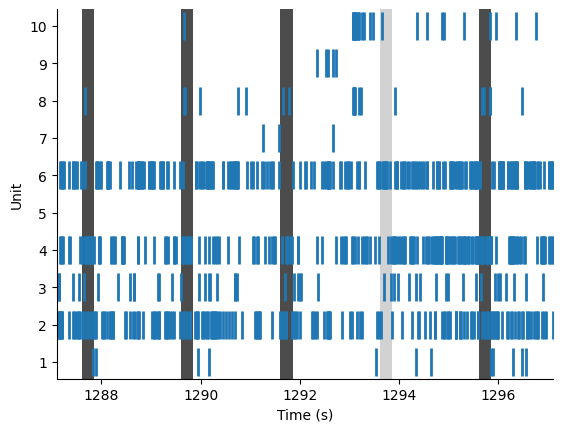

In [11]:
fig, ax = plt.subplots()

ax.plot(neurons_to_plot, "|", markersize=20, mew=2)

# Different coloured flashes
[ax.axvspan(s, e, color = "silver", alpha=.7, ec=None) for s, e in zip(white_flashes[:n_flashes].start, white_flashes[:n_flashes].end)]
[ax.axvspan(s, e, color = "black", alpha=.7, ec=None) for s, e in zip(black_flashes[:n_flashes].start, black_flashes[:n_flashes].end)]

plt.xlabel("Time (s)")
plt.ylabel("Unit")
plt.xlim(START + offset, START + offset + n_seconds)

# Only use integer values for ticks
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

### Selecting most relevant units
Units can be excluded from analysis for various reasons. We've already filtered based on recording quality, firing rate (above 2 Hz), and brain area. However, in the context of GLM modeling, where the goal is to predict firing rate as a function of stimuli, we are now specifically interested in how neurons respond to white and/or black flashes.

To focus on meaningful signal, we will exclude units that show no spiking activity during stimulus presentation. Additionally, we will select the most responsive units for further analysis.

[I Should add some info on neurons that activate only when stimulus arent there] (?)

[I should explain here what a perievent is]

In [12]:
# <- Need to find a way to reindex neurons so they're easily identifyiable??

# Get perievents
peri_white, peri_black = extract_perievents(units_visp, flashes)

# Get average responsiveness
responsive_white = get_responsiveness(peri_white, BIN_SIZE)
responsive_black = get_responsiveness(peri_black, BIN_SIZE)

# Find units with average 0 responsiveness before
# and after stimulus presentation
units_to_remove_white = [
    k for k, v in responsive_white.items()
    if v.get("pre_stim_av") <= 0 and v.get("post_stim_av") <= 0
]
units_to_remove_black = [
    k for k, v in responsive_black.items()
    if v.get("pre_stim_av") <= 0 and v.get("post_stim_av") <= 0
]
units_to_remove = list(set(units_to_remove_white) & set(units_to_remove_black))

# Create subset only including relevant units for further analysis
units_to_keep = [unit for unit in units_visp.keys() if unit not in units_to_remove]
units_visp_subset = units_visp[units_to_keep]

/Users/camilamaura/coding_projects/openscope_databook/docs/higher-order/glm_utils.py:142: RuntimeWarning: invalid value encountered in scalar divide
  responsiveness = (post_stim_av - pre_stim_av) / (post_stim_av + pre_stim_av)


### Select most responsive units

Now we want to see whether the remaining neurons are in fact responsive to the presented stimuli. 

For this, we will select the most responsive units and plot a "perievent" (close to event).

For a rough estimate of responsiveness, we will use:
    
    FR[.1s] - FR[-1.s] / FR[.1s] + FR[-1.s]

(is there a citation for this?)

In [13]:
peri_white, peri_black = extract_perievents(units_visp_subset, flashes)

responsive_white = get_responsiveness(peri_white, BIN_SIZE)
top_keys_peri_white = get_top_responsive_units(responsive_white, units_visp_subset)

responsive_black = get_responsiveness(peri_black, BIN_SIZE)
top_keys_peri_black = get_top_responsive_units(responsive_black, units_visp_subset)

# All subsequent analyses will be carried out with this subset of neurons
top_neurons_white = units_visp_subset[top_keys_peri_white]
top_neurons_black = units_visp_subset[top_keys_peri_black]

/Users/camilamaura/coding_projects/openscope_databook/docs/higher-order/glm_utils.py:142: RuntimeWarning: invalid value encountered in scalar divide
  responsiveness = (post_stim_av - pre_stim_av) / (post_stim_av + pre_stim_av)


### Perievent

In [14]:
## Plot definition side by side
def plot_peri_side_by_side(params,
                           bin_sz,
                           simulation = False,
                           smoothing = 0.02):
    """ Top neurons should be range from 0 to last shape dim in case of simulation
    """
    peri_white, top_neurons_white, peri_black, top_neurons_black = params
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # 1 row, 2 columns

    # Plot White
    ax = axs[0]
    
    for unit in top_neurons_white:
        if simulation: 
            peri_u = np.mean(peri_white,axis=1)[:,unit]
            ax.plot(peri_u, linewidth=1)
        else:
            peri_u = peri_white[unit]
            peri_u_count = peri_u.count(bin_sz)

            peri_u_coun_conv_mean = np.mean(peri_u_count, 1).smooth(std=smoothing)
            peri_u_rate_conv = peri_u_coun_conv_mean / bin_sz
            ax.plot(peri_u_rate_conv, linewidth=1)
    

    ax.set_xlim(-0.25, 0.50)
    ax.axvspan(0, 0.250, color="silver", alpha=0.3, ec=None)
    ax.axvline(0.0, color="black")
    ax.set_ylabel("Firing rate (Hz)")
    ax.set_title("Perievent white flashes")

    # Plot Black
    ax = axs[1]
    for unit in top_neurons_black:
        if simulation: 
            peri_u = np.mean(peri_black,axis=1)[:,unit]
            ax.plot(peri_u, linewidth=1)
        else:
            peri_u = peri_black[unit]
            peri_u_count = peri_u.count(bin_sz)

            peri_u_coun_conv_mean = np.mean(peri_u_count, 1).smooth(std=smoothing)
            peri_u_rate_conv = peri_u_coun_conv_mean / bin_sz
            ax.plot(peri_u_rate_conv, linewidth=1)

    ax.set_xlim(-0.25, 0.50)
    ax.axvspan(0, 0.250, color="black", alpha=0.3, ec=None)
    ax.axvline(0.0, color="black")
    ax.set_title("Perievent black flashes")

    plt.tight_layout()
    plt.show()


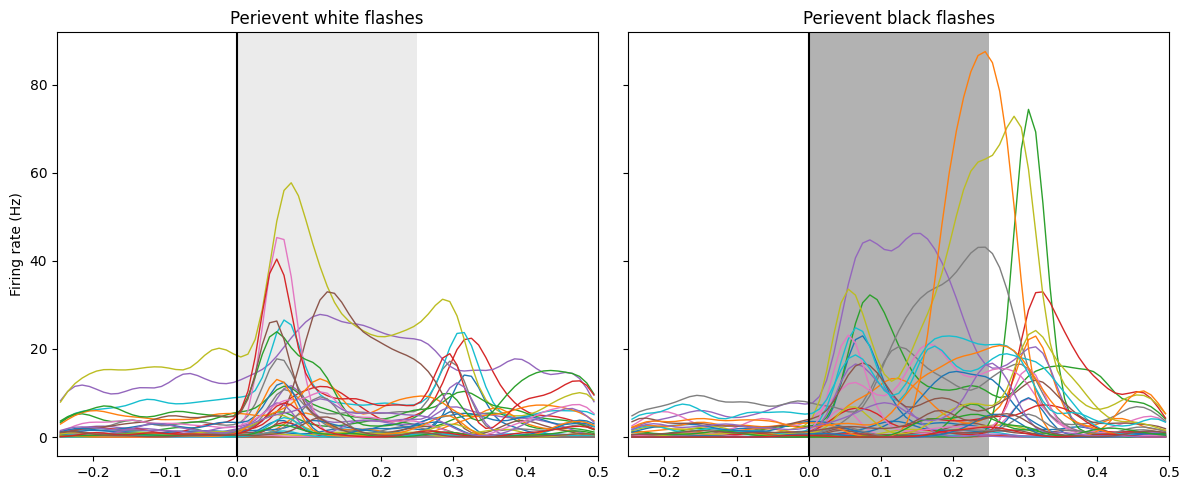

In [15]:
params_obs = [peri_white, 
              top_keys_peri_white, 
              peri_black, 
              top_keys_peri_black
]

plot_peri_side_by_side(params_obs,
                       BIN_SIZE
)

These neurons spiking rate certainly seems modulated by the flashes presentation. Lets keep those for the following analyses.

Here I would put an explanation for the duration of the filter. Id actually say that maybe the filter should be a bit longer? at least according to the perievent plots. 

## Nemos: Fitting a GLM

Have to explain why I am using:
- Raised Cosine Log
- Conv

### Building the basis
- Why use a basis?


In [16]:
def retrieve_stim_info(color_code, features, flashes):
    """Retrieve stimulus information based on color code.

    Parameters
    ----------
    color_code : 
        The color label (e.g., '-1.0' for black, '1.0 for white) to identify the stimulus.
    features : 
        An array indicating which flash interval each timestamp belongs to.

    Returns
    ----------
    color_feature: 
        A binary array where 1 indicates the timestamp falls within a flash 
        interval of the given color_code, and 0 otherwise.
    """
    # Get the indices of flash intervals where the color matches the given color_code
    intervals = flashes.index[flashes["color"] == color_code]
    # Initialize an array of zeros with the same length as the features array
    color_feature = np.zeros(len(features))
    # Create a boolean mask for entries in 'features' that match the target flash intervals
    mask = np.isin(features, intervals)
    # Mark the matching timestamps with 1
    color_feature[mask] = 1

    return color_feature

- It is good practice to split the data in two chunks: training and testing data. The first chunk is used to train the model; the second, to asses its performance. The reason why we do this is to accurately assess the performance of the model. If we train and evaluate the model in the same data, this results in a biased  model which will yield high accuracy in the dataset it was trained with, which won't be representative of it's performance on any other dataset.

- This splitting can be done in different ways. Here, we will take a chunk for trai is known as  "cross-validation" and there is no one-size-fits-all strategy for it, as the best strategy will depend on the type of data and the model. [continue]

In [17]:
# Set number of time bins
length = int((END-START)//BIN_SIZE)

# Drop unnecessary metadata
drop_list = [k for k in units_visp_subset.metadata_columns if k != "rate"]
units_visp_subset.drop_info(drop_list)

In [18]:
# Define cutting points for train and test set
DURATION = END-START
train_times = nap.IntervalSet(START, START + DURATION * .5)
test_times = nap.IntervalSet(START + DURATION * .5, END)

## TRAINING SET
# Create Tsd with timestamps corresponding to the desired time bins and bins sizes
spike_counts_visp_subset_train = units_visp_subset.count(BIN_SIZE, ep=train_times)

uniform_train = nap.Tsd(t=spike_counts_visp_subset_train.t, d=np.ones(spike_counts_visp_subset_train.shape[0]))

## TEST SET
spike_counts_visp_subset_test = units_visp_subset.count(BIN_SIZE, ep=test_times)
uniform_test = nap.Tsd(t=spike_counts_visp_subset_test.t, d=np.ones(spike_counts_visp_subset_test.shape[0]))

# Split flashes interval set into train and rest
flashes_train = flashes[flashes.end<=uniform_train.end]
flashes_test = flashes[flashes.start>uniform_train.end]

# For each desired timestamp, find the index of the flash interval it falls into.
# Returns NaN for timestamps outside all intervals, and an index for those within.
features_train = flashes_train.in_interval(uniform_train)
features_test = flashes_test.in_interval(uniform_test)

problem: make sure train and test set arrays contain the right information & that they are aligned

In [19]:
white_stimuli_train = retrieve_stim_info("1.0", features_train, flashes_train)
black_stimuli_train = retrieve_stim_info("-1.0", features_train, flashes_train)

white_stimuli_test = retrieve_stim_info("1.0", features_test, flashes_test)
black_stimuli_test = retrieve_stim_info("-1.0", features_test, flashes_test)

In [20]:
tsd_white_train = nap.Tsd(t = spike_counts_visp_subset_train.t, d = white_stimuli_train)
tsd_black_train = nap.Tsd(t = spike_counts_visp_subset_train.t, d = black_stimuli_train)

tsd_white_test = nap.Tsd(t = spike_counts_visp_subset_test.t, d = white_stimuli_test)
tsd_black_test = nap.Tsd(t = spike_counts_visp_subset_test.t, d = black_stimuli_test)


In [21]:
# Create basis for training
window_length = int(0.25 / BIN_SIZE)

bas = nmo.basis.RaisedCosineLogConv(n_basis_funcs = 5, window_size = window_length, label = "w") + nmo.basis.RaisedCosineLogConv(n_basis_funcs = 5, window_size = window_length, label = "b")

X_train = bas.compute_features(tsd_white_train, tsd_black_train)
X_test = bas.compute_features(tsd_white_test, tsd_black_test)

/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'ArrayImpl'.
  warnings.warn(
/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'ArrayImpl'.
  warnings.warn(
/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'ArrayImpl'.
  warnings.warn(
/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'ArrayImpl'.
  warnings.warn(


### Fitting the model

As mentioned before, we will use most responsive neurons for black and white stimuli for fitting.

As such, we will select only neurons on the top 30% responsiveness in at least one stimulus

are the top responsive neurons the same? are they different? (selective to one stimuli only)

In [22]:
top_neurons_both = sorted(list(set(top_neurons_black.keys()) | set(top_neurons_white.keys())))

# Use most resposive neurons
units_visp_subset_top = units_visp_subset[top_neurons_both]

# Split in test and train
spikes_visp_subset_top_count_train = units_visp_subset_top.count(BIN_SIZE, ep=train_times)
spikes_visp_subset_top_count_test = units_visp_subset_top.count(BIN_SIZE, ep=test_times)

In [23]:
reg_strength = 0.01 #This should be checked with cross validation

model_base = nmo.glm.PopulationGLM(
    regularizer = "Ridge",
    regularizer_strength = reg_strength,
    solver_name="LBFGS", 
    solver_kwargs=dict(tol=10**-12))

model_base.fit(
    X_train,
    spikes_visp_subset_top_count_train
)

PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=Ridge(),
    regularizer_strength=0.01,
    solver_name='LBFGS',
    solver_kwargs={'tol': 1e-12}
)

## Nemos: evaluating GLM
To assess whether the glm captures the data, let's predict spike rates.

I'll plot the rates in a perievent time histogram, so we can see whether the activity matches the observed patterns

### Perievent

In [24]:
pred_pop = model_base.predict(X_test)/ BIN_SIZE

pred_tsd_pop = nap.TsdFrame(t=spikes_visp_subset_top_count_test.t, d=pred_pop)

peri_white_sim, peri_black_sim = extract_perievents(pred_tsd_pop, flashes_test, continuous=True) 

# Excluding last trial from matrix because the last stimulus presented
# was a black one and after it's presented the time series is cut so
# it's all nans
peri_black_sim_new  = peri_black_sim[:,:-1,:]

/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'TsdFrame'.
  warnings.warn(


In [25]:
params_sim = [peri_white_sim,
              range(peri_white_sim.shape[2]),
              peri_black_sim_new,
              range(peri_black_sim.shape[2])
              ]

peri_white_test, peri_black_test = extract_perievents(units_visp_subset_top.restrict(test_times), flashes_test)

params_obs_test = [peri_white_test,
                   top_keys_peri_white,
                   peri_black_test,
                   top_keys_peri_black
            ]

In [26]:
'''plot_peri_side_by_side(params_sim,
                       BIN_SIZE,
                       simulation=True
)'''

'plot_peri_side_by_side(params_sim,\n                       BIN_SIZE,\n                       simulation=True\n)'

In [27]:
def plot_peri_both(params_obs,
                   params_sim,
                   bin_sz,
                   simulation = False,
                   smoothing = 0.02,
                   n_cells = 5):
    """ Top neurons should be range from 0 to last shape dim in case of simulation
    """
    peri_white_obs, top_neurons_white_obs, peri_black_obs, top_neurons_black_obs = params_obs
    peri_white_sim, top_neurons_white_sim, peri_black_sim, top_neurons_black_sim = params_sim

    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)  # 1 row, 2 columns

    # Plot White
    ax = axs[0]
    
    # Set colors obs
    n_lines = len(top_neurons_white_obs)

    cmap_obs = mpl.colormaps['Blues']
    colors_obs = cmap_obs(np.linspace(0.5, 1, n_lines))

    # Set colors sim
    cmap_sim = mpl.colormaps['Reds']
    colors_sim = cmap_sim(np.linspace(0.5, 1, n_lines))

    label_sim_added = False
    label_obs_added = False

    for unit_sim, unit_obs in enumerate(top_neurons_white_obs[:n_cells]):
        peri_u_sim = np.mean(peri_white_sim,axis=1)[:,unit_sim]
        if not label_sim_added:
            ax.plot(peri_u_sim, linewidth=1, color = colors_sim[unit_sim], label = "Simulated")
            label_sim_added = True
        else: 
            ax.plot(peri_u_sim, linewidth=1, color = colors_sim[unit_sim])
    
        peri_u_obs = peri_white_obs[unit_obs]
        peri_u_count_obs = peri_u_obs.count(bin_sz)
        peri_u_count_conv_mean_obs = np.mean(peri_u_count_obs, 1).smooth(std=smoothing)
        peri_u_rate_conv_obs = peri_u_count_conv_mean_obs / bin_sz
        if not label_obs_added:
            ax.plot(peri_u_rate_conv_obs, linewidth=1, color = colors_obs[unit_sim], label="Observed")
            label_obs_added = True
        else:
            ax.plot(peri_u_rate_conv_obs, linewidth=1, color = colors_obs[unit_sim])

    ax.set_xlim(-0.25, 0.50)
    ax.axvspan(0, 0.250, color="silver", alpha=0.3, ec=None)
    ax.axvline(0.0, color="black")
    ax.set_ylabel("Firing rate (Hz)")
    ax.set_title("Perievent white flashes")

    label_sim_added = False
    label_obs_added = False

    # Plot Black
    ax = axs[1]
    for unit_sim, unit_obs in enumerate(top_neurons_black_obs[:n_cells]):
        peri_u_sim = np.mean(peri_black_sim,axis=1)[:,unit_sim]
        if not label_sim_added:
            ax.plot(peri_u_sim, linewidth=1, color = colors_sim[unit_sim], label = "Simulated")
            label_sim_added = True
        else: 
            ax.plot(peri_u_sim, linewidth=1, color = colors_sim[unit_sim])


        peri_u_obs = peri_black_obs[unit_obs]
        peri_u_count_obs = peri_u_obs.count(bin_sz)
        peri_u_count_conv_mean_obs = np.mean(peri_u_count_obs, 1).smooth(std=smoothing)
        peri_u_rate_conv_obs = peri_u_count_conv_mean_obs / bin_sz
        if not label_obs_added:
            ax.plot(peri_u_rate_conv_obs, linewidth=1, color = colors_obs[unit_sim], label="Observed")
            label_obs_added = True
        else:
            ax.plot(peri_u_rate_conv_obs, linewidth=1, color = colors_obs[unit_sim])

    ax.set_xlim(-0.25, 0.50)
    ax.axvspan(0, 0.250, color="black", alpha=0.3, ec=None)
    ax.axvline(0.0, color="black")
    ax.set_title("Perievent black flashes")

    plt.tight_layout()
    plt.legend()
    plt.show()

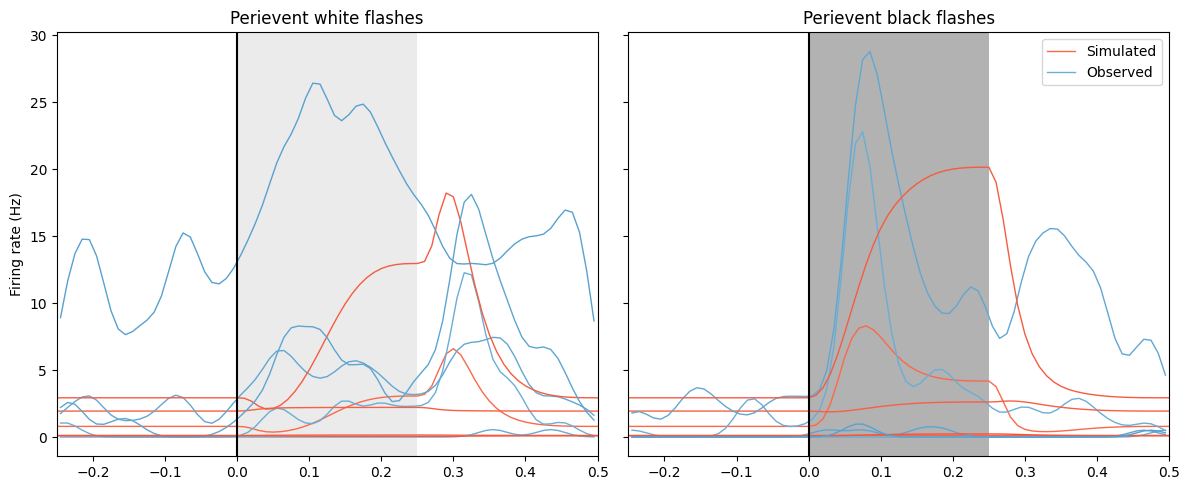

In [28]:
plot_peri_both(params_obs_test,
               params_sim,
               BIN_SIZE,
               n_cells=5)

## Adding history as a new predictor

Question: can we use the spiking activity of other neurons to predict the spiking activity of a neuron?

In [29]:
# New basis
hist_bas = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs=8, window_size=window_length, label="count_history"
)
stim_bas = bas

basis = stim_bas + hist_bas

X_hist_train = basis.compute_features(white_stimuli_train, black_stimuli_train, spikes_visp_subset_top_count_train)

X_hist_test = basis.compute_features(white_stimuli_test, black_stimuli_test, spikes_visp_subset_top_count_test)

/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'ArrayImpl'.
  warnings.warn(
/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'ArrayImpl'.
  warnings.warn(
/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'ArrayImpl'.
  warnings.warn(
/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'ArrayImpl'.
  warnings.warn(
/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 

In [30]:
# Fit with new basis as predictor
# Fitting pop model
reg_strength = 0.01 #This should be checked with cross validation

model_hist = nmo.glm.PopulationGLM(
    regularizer = "Ridge",
    regularizer_strength = reg_strength,
    solver_name="LBFGS", 
    solver_kwargs=dict(tol=10**-12))

model_hist.fit(X_hist_train,spikes_visp_subset_top_count_train)


PopulationGLM(
    observation_model=PoissonObservations(inverse_link_function=exp),
    regularizer=Ridge(),
    regularizer_strength=0.01,
    solver_name='LBFGS',
    solver_kwargs={'tol': 1e-12}
)

/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'ArrayImpl'.
  warnings.warn(
/Users/camilamaura/miniforge3/envs/databook/lib/python3.11/site-packages/pynapple/core/utils.py:196: UserWarning: Converting 'd' to numpy.array. The provided array was of type 'TsdFrame'.
  warnings.warn(


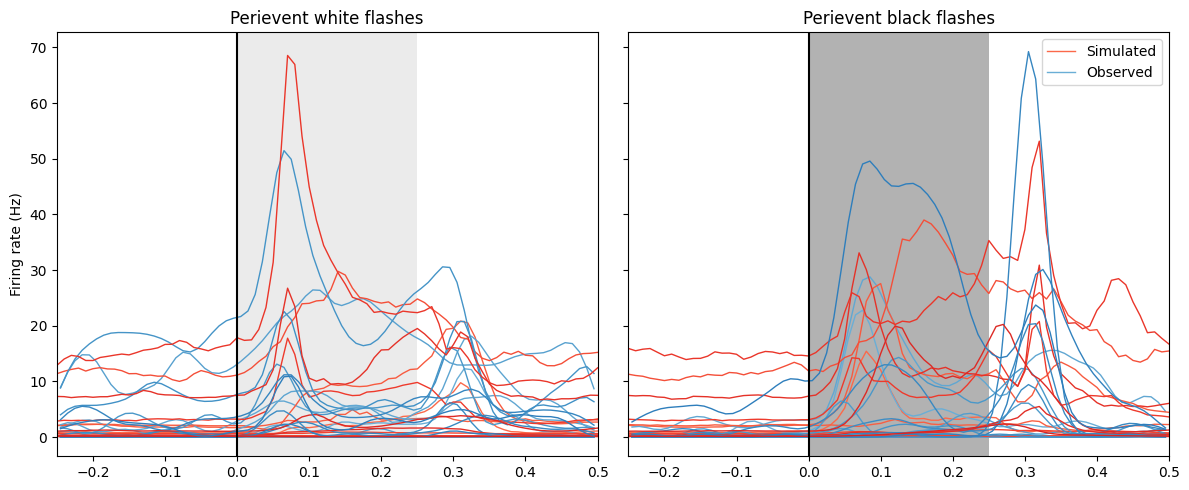

In [63]:
pred_pop = model_hist.predict(X_hist_test)/ BIN_SIZE

pred_tsd_pop = nap.TsdFrame(t=spikes_visp_subset_top_count_test.t, d=pred_pop)

peri_white_sim, peri_black_sim = extract_perievents(pred_tsd_pop, flashes_test, continuous=True) 

# Excluding last trial from matrix because the last stimulus presented
# was a black one and after it's presented the time series is cut so
# it's all nans
peri_black_sim_new  = peri_black_sim[:,:-1,:]

params_sim = [peri_white_sim,
              range(peri_white_sim.shape[2]),
              peri_black_sim_new,
              range(peri_black_sim.shape[2])
              ]

plot_peri_both(params_obs_test,
               params_sim,
               BIN_SIZE,
               n_cells=15)

## Evaluate performance

In [70]:
def evaluate_model(model, X, y, label, dataset_type):
    score = model.score(X, y, score_type='pseudo-r2-McFadden')
    full_label = f"{label} ({dataset_type})"
    print(f"{full_label} score: {score:.4f}")
    return full_label, score, dataset_type

def evaluate_models(models, X_sets, y_sets, dataset_label, dataset_type, results):
    for model_name, model in models.items():
        X = X_sets[model_name]
        y = y_sets
        label = f"{model_name} model {dataset_label}"
        results.append(evaluate_model(model, X, y, label, dataset_type))

def evaluate_models_by_color(models, X_sets, y_sets, flashes, color,dataset_type, results):
    color_code = "1.0" if color == "white" else "-1.0"
    flashes_color = flashes[flashes["color"] == color_code]

    for model_name, model in models.items():
        X = X_sets[model_name].restrict(flashes_color)
        y = y_sets.restrict(flashes_color)
        label = f"{color} {model_name} model"
        results.append(evaluate_model(model, X, y, label, dataset_type))

# Store all results
all_results = []

# Define model dictionary
models = {
    "base": model_base,
    "hist": model_hist
}

# Evaluate full sets
evaluate_models(models, {"base": X_train, "hist": X_hist_train}, spikes_visp_subset_top_count_train, "train", "train", all_results)
evaluate_models(models, {"base": X_test, "hist": X_hist_test}, spikes_visp_subset_top_count_test, "test", "test", all_results)

# Evaluate by color
evaluate_models_by_color(models, {"base": X_train, "hist": X_hist_train}, spikes_visp_subset_top_count_train, flashes_train, "white", "train", all_results)
evaluate_models_by_color(models, {"base": X_train, "hist": X_hist_train}, spikes_visp_subset_top_count_train, flashes_train, "black", "train", all_results)

evaluate_models_by_color(models, {"base": X_test, "hist": X_hist_test}, spikes_visp_subset_top_count_test, flashes_test, "white", "test", all_results)
evaluate_models_by_color(models, {"base": X_test, "hist": X_hist_test}, spikes_visp_subset_top_count_test, flashes_test, "black",  "test", all_results)

# Get best models
best_train = max([r for r in all_results if r[2] == "train"], key=lambda x: x[1])
best_test = max([r for r in all_results if r[2] == "test"], key=lambda x: x[1])

print(f"\nBest TRAIN model: {best_train[0]} with score {best_train[1]:.4f}")
print(f"Best TEST model:  {best_test[0]} with score {best_test[1]:.4f}")


base model train (train) score: 0.0687
hist model train (train) score: 0.1356
base model test (test) score: 0.0335
hist model test (test) score: 0.0786
white base model (train) score: 0.0270
white hist model (train) score: 0.0967
black base model (train) score: 0.0179
black hist model (train) score: 0.1088
white base model (test) score: 0.0038
white hist model (test) score: 0.0466
black base model (test) score: -0.0199
black hist model (test) score: 0.0420

Best TRAIN model: hist model train (train) with score 0.1356
Best TEST model:  hist model test (test) with score 0.0786


- Probably this will look better if I have it in dict form
- Is the prediction so bad because the window for the black one should be larger?

Final remarks?